# **Imports and Constants**

In [67]:
#find spark
import findspark
findspark.init()

In [68]:
#imports
from __future__ import print_function
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql.functions import col
from functools import reduce
from pyspark import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, size, isnan, array_contains, when, count, pandas_udf, PandasUDFType
from pyspark.sql.types import *
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import pandas as pd 
import glob
import re
import pathlib
import json
import datetime
import numpy as np
import time
import os
import random
import statistics
import pathlib
import platform

#env variables 
if platform.system()=='Windows':
    %env PYSPARK_DRIVER_PYTHON=python
    %env PYSPARK_PYTHON=python
elif platform.system()=='Linux':
    %env PYSPARK_DRIVER_PYTHON=python
    %env PYSPARK_PYTHON=python3
else:
    %env PYSPARK_DRIVER_PYTHON=python3.6 
    %env PYSPARK_PYTHON=python3.6 

#incompatibility with Pyarrow
#need to install Pyarrow 0.14.1 or lower or Set the environment variable ARROW_PRE_0_15_IPC_FORMAT=1
%env ARROW_PRE_0_15_IPC_FORMAT=1 

#used versions: 
#spark='2.4.3' python='3.6' pyarrow='0.14.1' 

#for new system:
#import findspark
#findspark.init()
#%pip install numpy
#%pip install -U matplotlib
#%pip install pandas
#%pip install Pyarrow==0.14.0
#%env PYSPARK_DRIVER_PYTHON=python
#%env PYSPARK_PYTHON=python

env: PYSPARK_DRIVER_PYTHON=python3.6
env: PYSPARK_PYTHON=python3.6
env: ARROW_PRE_0_15_IPC_FORMAT=1


In [69]:
#paths

BASE_PATH=pathlib.Path().absolute()

KMEANS_REL_PATH="kmeans models"
DATASET_REL_PATH="dataset"


DATASET_PATH=os.path.join(BASE_PATH,DATASET_REL_PATH)
KMEANS_PATH=os.path.join(BASE_PATH,KMEANS_REL_PATH)

#print(DATASET_PATH)
#print(KMEANS_PATH)

#from google.colab import drive
#drive.mount('/gdrive')

# **Load/Save Dataset**

In [70]:
#load and save .read_pickle() and .to_pickle() 

#save
#dataset.to_pickle(DATASET_PATH+"dataset.pkl")
#aggregated_dataset.to_pickle(DATASET_PATH+"aggregated_dataset.pkl")
#json_dataset.to_pickle(DATASET_PATH+"json_dataset.pkl")
#dataset.to_csv(DATASET_PATH+"dataset.csv")
#aggregated_dataset.to_csv(DATASET_PATH+"aggregated_dataset.csv")
#json_dataset.to_csv(DATASET_PATH+"json_dataset.csv")
#aggregated_dataset_rowBased.to_csv(DATASET_PATH+"aggregated_dataset_rowBased.csv")

#load
dataset=pd.read_pickle(os.path.join(DATASET_PATH, 'dataset.pkl'))
aggregated_dataset=pd.read_pickle(os.path.join(DATASET_PATH, 'aggregated_dataset.pkl'))
json_dataset=pd.read_pickle(os.path.join(DATASET_PATH, 'json_dataset.pkl'))

# **Malicious Samples**

In [71]:
# Generate malicious samples
def h1(x):
    MAX=0.8
    MIN=0.1
    alpha=random.uniform(MIN,MAX)
    temp=np.array(x)
    return (temp*alpha).tolist()

def h2(x):
    MIN_OFF=4 # hour
    DURATION=random.randint(MIN_OFF,23)
    START=random.randint(0,23-DURATION) if DURATION!=23 else 0
    END=START+DURATION
    temp=[]
    for i in range(len(x)):
        if i<START or i>=END:
            temp.append(x[i])
        else:
            temp.append(0.0)
    return temp
    
def h3(x):
    MAX=0.8
    MIN=0.1
    temp=[]
    for i in range(len(x)):
        temp.append(x[i]*random.uniform(MIN,MAX))
    return temp

def h4(x):
    MAX=0.8
    MIN=0.1
    mean=np.mean(x)
    temp=[]
    for i in range(len(x)):
        temp.append(mean*random.uniform(MIN,MAX))
    return temp

def h5(x):
    MAX=0.8
    MIN=0.1
    mean=np.mean(x)
    temp=[]
    for i in range(len(x)):
        temp.append(mean)
    return temp

def h6(x):
    temp=np.array(x)
    #temp=temp[::-1] 
    temp=np.flipud(temp) 
    return temp.tolist()

In [72]:
#plot

def plot_malicious_samples():
    read_value=[96.00396728515625, 68.20671844482422, 96.05184936523438, 81.24053192138672, 107.14600372314453, 85.7899169921875, 100.9619140625, 181.16192626953125, 122.7833023071289, 119.53163146972656, 107.34815216064453, 108.99268341064453, 139.76922607421875, 97.21031951904297, 118.4515151977539, 99.15070343017578, 85.47505187988281, 81.51718139648438, 232.91493225097656, 82.83419799804688, 108.6827163696289, 95.99102020263672, 90.59868621826172, 85.60449981689453]
    lists=[]
    colors=['b','r-','g--','c:','m-.','y-','k--']
    lists.append(read_value)
    lists.append(h1(read_value))
    lists.append(h2(read_value))
    lists.append(h3(read_value))
    lists.append(h4(read_value))
    lists.append(h5(read_value))
    lists.append(h6(read_value))
    plt.figure(num=None, figsize=(14, 9), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel("Hour")
    plt.ylabel("Power")
    plt.title("malicious samples")
    plt.plot(read_value)
    for i in range(len(lists)):
        plt.plot(lists[i],colors[i],label = 'H %s'%i)
    plt.legend()
    plt.show()
    return None

#plot_malicious_samples()


# **Prepare Spark Dataset**

In [73]:
#rename columns
def rename_dataframe(sdf):
    names = ['#','date','id','power']
    for c,n in zip(sdf.columns,names):
        sdf=sdf.withColumnRenamed(c,n)
    return sdf
    
#sdf=rename_dataframe(sdf)
#sdf.show()
    
#convert power to array
def string_power_to_array(sdf):
    temp=sdf.withColumn("power", f.regexp_replace(f.regexp_replace(f.col("power"), "\\[", ""),"\\]","")
                        .alias("power"))
    temp=temp.withColumn("power",split(col("power"), ",\s*")
                        .cast(ArrayType(FloatType())).alias("power"))
    return temp

#sdf=string_power_to_array(sdf)
#sdf.show()

def add_validation_column(sdf):
    def validation(x):
        res=[]
        for row in x:
            v=True
            if (len(row)!= 24 or # unusual size
                (row>=0).sum()!=24 or #number of valid elements = 24
                #sum(n >= 0 for n in row) != 24 or 
                np.count_nonzero(row == 0)>=3 or #equal or more than 3 zero elements
                sum(n < 0 for n in row) > 0): #not have negative element
                    v=False
            res.append(v)
        return pd.Series(res)
    validation_UDF = pandas_udf(validation, returnType=BooleanType())
    temp=sdf.withColumn("V",validation_UDF(col("power")))
    return temp

#sdf=add_validation_column(sdf)
#sdf.show()


#add "N"ormal consumption ("N"onmalicious) column
def add_Normal_column(sdf):
    N=True
    temp=sdf.withColumn("N", f.lit(N))
    return temp

#sdf=add_Normal_column(sdf)
#sdf.show()

#filter data
def filter_dataset(sdf,from_date="BEGIN",to_date="END",ID="*",V="*"):
    temp=sdf
    if (from_date!="BEGIN"):
        temp=temp.filter(sdf.date > from_date) #filter date (from X)
    if (to_date!="END"):
        temp=temp.filter(sdf.date < to_date) #filter date (to Y)
    if (ID!="*"):
        temp=temp.filter(sdf.id == ID) #filter IDs
    if (V!="*"):
        temp=temp.filter(sdf.V == V) #filter validation    
    return temp

#sdf=filter_dataset(sdf,from_date="BEGIN",to_date="END",ID="Apt36",V="True")
#sdf.show()

def split_power(sdf):
    temp=sdf.select("#","date","id",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
    return temp
    
#split_sdf=split_power(sdf)
#sdf.show()

#make id list
def get_ids(sdf):
    IDs=np.array(sdf.select("id").distinct().collect())
    IDs=IDs.reshape(1,len(IDs))
    return IDs


#generate uniqe id
def generate_uniqe_id(sdf):
    temp=sdf
    temp=temp.withColumn("uid",f.concat(col("id"),f.lit("-"),col("#")).alias("uid"))
    return temp

#sdf=generate_uniqe_id(sdf)


#sdf.show()
#print("number of rows: " + str(sdf.count()))
#sdf.collect()
#sdf.printSchema()
#split_sdf=add_validation_column(split_sdf)

In [74]:
#add malicious samples
def create_malicious_df(sdf):
    def random_attack_assigner(x):
        NUMBER_OF_MALICIOUS_GENERATOR=6
        res=[]
        for row in x:
            rand = random.randint(1,NUMBER_OF_MALICIOUS_GENERATOR)
            if rand==1:
                temp=(h1(row))
            elif rand==2:
                temp=(h2(row))
            elif rand==3:
                temp=(h3(row))
            elif rand==4:
                temp=(h4(row))
            elif rand==5:
                temp=(h5(row))
            elif rand==6:
                temp=(h6(row))
            res.append(temp)
        return pd.Series(res)
    random_attack_assigner_UDF = pandas_udf(random_attack_assigner, returnType=ArrayType(FloatType()))
    sdf_malicious=sdf
    N=False
    sdf_malicious=sdf_malicious.withColumn("N", f.lit(N)) #malicious sample
    sdf_malicious=sdf_malicious.withColumn("#", col("#")*-1) # change '#' column number to negative
    sdf_malicious=sdf_malicious.withColumn("power",random_attack_assigner_UDF(col("power")))
    return sdf_malicious


# **K-Means**

In [75]:
def prepare_for_kmeans(sdf): 
    
    temp=sdf
    
    #define function for split power column
    def split_power(sdf):
        temp=sdf.select("#", "V", "N", "date", "id", "uid",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
        return temp
    
    #call the split_power function
    temp=split_power(temp)
    
    #filter date
    #temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    #temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp=temp.filter(temp.V==True) #filter valid rows
    
    FEATURES = ['H0', 'H1', 'H2','H3', 'H4', 'H5','H6', 'H7', 'H8','H9', 'H10', 'H11',
            'H12', 'H13', 'H14','H15', 'H16', 'H17','H18', 'H19', 'H20','H21', 'H22', 'H23']
    
    #call the generate_uniqe_id function
    temp=generate_uniqe_id(temp)
    
    #make ready
    vecAssembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    df_kmeans = vecAssembler.transform(temp).select(col("uid"), col("features"))
    return df_kmeans


In [76]:
#run k-means

def kmeans(sdf_kmeans):
    #find best k
    MAX_k=5
    costs = np.zeros(MAX_k)
    silhouettes = np.zeros(MAX_k)
    silhouettes[1]=0 #set value for k=1
    for k in range(2,MAX_k):
        kmeans = KMeans().setK(k).setSeed(1)
        model = kmeans.fit(sdf_kmeans)
        costs[k] = model.computeCost(sdf_kmeans) # requires Spark 2.0 or later
        predictions = model.transform(sdf_kmeans)
        evaluator = ClusteringEvaluator()
        silhouettes[k] = evaluator.evaluate(predictions)

#     #show silhouette
#     fig, ax = plt.subplots(1,1, figsize =(8,6))
#     ax.plot(range(2,MAX_k),silhouettes[2:MAX_k])
#     ax.set_xlabel('k')
#     ax.set_ylabel('silhouette')

#     #show cost
#     fig, ax = plt.subplots(1,1, figsize =(8,6))
#     ax.plot(range(2,MAX_k),costs[2:MAX_k])
#     ax.set_xlabel('k')
#     ax.set_ylabel('cost')

    # find best k
    best_k = np.argmax(silhouettes)
    print("maximum value of silhouette is: " + str(silhouettes[best_k]) + " in index: " + str(best_k) )

    # Trains a k-means model.
    kmeans = KMeans().setK(best_k).setSeed(1)
    model = kmeans.fit(sdf_kmeans)

    # Make predictions
    predictions = model.transform(sdf_kmeans)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
#    print("Silhouette with squared euclidean distance = " + str(silhouette))

#     # Shows the result.
#     centers = model.clusterCenters()
#     print("Cluster Centers: ")
#     for center in centers:
#         print(center)

#     transformed = model.transform(sdf_kmeans).select('id', 'prediction')
#     transformed.show()
#     transformed.groupby('prediction').count().show()
#     rows = transformed.collect() 
#     prediction = spark.createDataFrame(rows)
#     prediction.show()
    return model,best_k,silhouette


# **Decision Tree Methods**

In [77]:
def prepare_for_decision_tree_methods(sdf): 
    
    temp=sdf
    
    #define function for split power column
    def split_power(sdf):
        temp=sdf.select("#", "V", "N", "date", "id", "uid",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
        return temp
    
    #call the split_power function
    temp=split_power(temp)
    
    #boolean to string (for "N" column)
    temp=temp.withColumn("N",f.col("N").cast('string'))
    #temp.printSchema()
    
    
    #filter date
    #temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    #temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp=temp.filter(temp.V==True) #filter valid rows
    
    FEATURES = ['H0', 'H1', 'H2','H3', 'H4', 'H5','H6', 'H7', 'H8','H9', 'H10', 'H11',
            'H12', 'H13', 'H14','H15', 'H16', 'H17','H18', 'H19', 'H20','H21', 'H22', 'H23']
    
    #call the generate_uniqe_id function
    #temp=generate_uniqe_id(temp)
    
    #make features ready
    assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    output = assembler.transform(temp)
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    
    #make label ready
    indexer = StringIndexer(inputCol="N", outputCol="NIndex")
    output_fixed = indexer.fit(output).transform(output)
    
    final_data = output_fixed.select("features",'NIndex')
    return final_data


In [78]:
#run decision tree methods
def decision_tree(train_data,test_data):
    dtc = DecisionTreeClassifier(labelCol='NIndex',featuresCol='features')
    rfc = RandomForestClassifier(labelCol='NIndex',featuresCol='features') #,numTrees=100
    gbt = GBTClassifier(labelCol='NIndex',featuresCol='features')

    dtc_model = dtc.fit(train_data)
    rfc_model = rfc.fit(train_data)
    gbt_model = gbt.fit(train_data)

    dtc_predictions = dtc_model.transform(test_data)
    rfc_predictions = rfc_model.transform(test_data)
    gbt_predictions = gbt_model.transform(test_data)
    
    #evaluation
    # Select (prediction, true label) and compute test error
    acc_evaluator = MulticlassClassificationEvaluator(labelCol="NIndex", predictionCol="prediction", metricName="accuracy")

    dtc_acc = acc_evaluator.evaluate(dtc_predictions)
    rfc_acc = acc_evaluator.evaluate(rfc_predictions)
    gbt_acc = acc_evaluator.evaluate(gbt_predictions)

    #print('A single decision tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
    #print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
    #print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(gbt_acc*100))
    
    return dtc_acc,rfc_acc,gbt_acc


# **PCA**

In [79]:
def prepare_for_pca(sdf): 
    
    temp=sdf
    
    #define function for split power column
    def split_power(sdf):
        temp=sdf.select("#", "V", "N", "date", "id", "uid",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
        return temp
    
    #call the split_power function
    temp=split_power(temp)
    
    temp=temp.filter(temp.V==True) #filter valid rows
    
    FEATURES = ['H0', 'H1', 'H2','H3', 'H4', 'H5','H6', 'H7', 'H8','H9', 'H10', 'H11',
            'H12', 'H13', 'H14','H15', 'H16', 'H17','H18', 'H19', 'H20','H21', 'H22', 'H23']

    #call the generate_uniqe_id function
    temp=generate_uniqe_id(temp)
    
    #make ready
    vecAssembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    df_pca = vecAssembler.transform(temp).select("#", "V", "N", "date", "id", "uid", col("features"))
    return df_pca


def pca_for_tree(sdf):
    #sdf = prepare_for_pca(sdf)
    pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
    model = pca.fit(sdf)
    result = model.transform(sdf).select("NIndex",col("pcaFeatures").alias("features"))
    return result


def pca_for_kmeans(sdf):
    #sdf = prepare_for_pca(sdf)
    pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
    model = pca.fit(sdf)
    result = model.transform(sdf).select("uid",col("pcaFeatures").alias("features"))
    return result


#sdf_pca=pca(sdf)
#sdf_pca.show() #truncate=False

# **Main**

In [82]:
#create SparkSession
spark = SparkSession.builder.appName("anomaly_detection").master("local[20]").getOrCreate()
#network problem? type it in commandline: sudo hostname -s 127.0.0.1

#define schema
schema = StructType([
    StructField("#", IntegerType()),
    StructField("date", TimestampType()),
    StructField("id", StringType()),
    StructField("power", StringType())])

#read data
sdf = spark.read.format('csv').options(header='true',inferSchema=True ,schema=schema).load(
    os.path.join(DATASET_PATH, 'aggregated_dataset_rowBased.csv'))


sdf=rename_dataframe(sdf)
sdf=string_power_to_array(sdf)
sdf=add_validation_column(sdf)
sdf=add_Normal_column(sdf)
sdf=filter_dataset(sdf,from_date="BEGIN",to_date="END",ID="*",V="True")
sdf=generate_uniqe_id(sdf)

#ids
id_list=get_ids(sdf)


# #dataset
# print("dataframe schema:")
# print("number of rows: " + str(sdf.count()))
# sdf.printSchema()
# print("benign dataframe (sdf):")
# sdf.show()

# #generate malicious data
# sdf_malicious=create_malicious_df(sdf)
# print("malicious dataframe (sdf_malicious):")
# sdf_malicious.show()
# sdf_mix= sdf.union(sdf_malicious)
# print("final dataframe (sdf_mix):")
# sdf_mix.show()


In [83]:
#kmeans separately

def call_kmeans(sdf):
    
    #create statistics dataframe
    kmeans_statistics_schema = StructType([
    StructField("id", StringType()),
    StructField("k", IntegerType()),
    StructField("Silhouette", FloatType())])

    kmeans_statistics = spark.createDataFrame([], kmeans_statistics_schema)    
    
    id_list=get_ids(sdf)
    sdf_kmeans=prepare_for_kmeans(sdf) # replace sdf with final_sdf for clustring benign and malicious data
    sdf_kmeans=pca_for_kmeans(sdf_kmeans) #0.8725788926917551 to 0.9101118371931005
    #sdf_kmeans.show()
    iteration=1
    for i in np.nditer(id_list):
        sdf_kmeans_by_id = sdf_kmeans.filter(sdf_kmeans.uid.like(str(i)+"-"+"%")) #filter IDs
        print("customer "+ str(iteration)+": "+ str(i))
        #sdf_kmeans_by_id.show()
        kmeans_model,best_k,silhouette=kmeans(sdf_kmeans_by_id)
        #kmeans_model.save(os.path.join(KMEANS_PATH,str(i)))
        
        newRow_for_statistics = spark.createDataFrame([(str(i), int(best_k), float(silhouette))])
        kmeans_statistics = kmeans_statistics.union(newRow_for_statistics)
        
        iteration+=1
        #model_name = KMeansModel.load(os.path.join(KMEANS_PATH,str(i)) #for load model
    return kmeans_statistics

print("-------------------- k-means started!")
kmeans_statistics=call_kmeans(sdf)
kmeans_statistics.show()
#save
# result_pdf = kmeans_statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'kmeans_statistics.pkl'))
#load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'kmeans_statistics.pkl'))
#df.head()

-------------------- k-means started!
customer 1: Apt107


KeyboardInterrupt: 

In [65]:
#decision tree separately
def call_trees(sdf):
    
    #create statistics dataframe
    trees_statistics_schema = StructType([
    StructField("id", StringType()),
    StructField("dtc", FloatType()),
    StructField("rfc", FloatType()),
    StructField("gbt", FloatType())])

    trees_statistics = spark.createDataFrame([], trees_statistics_schema)  
    
    id_list=get_ids(sdf)
    
    iteration=1
    for i in np.nditer(id_list):
        sdf_trees_by_id = sdf.filter(sdf.uid.like(str(i)+"-"+"%")) #filter IDs
        print("customer "+ str(iteration)+": "+ str(i))
        
        sdf_trees=prepare_for_decision_tree_methods(sdf)
        train_data,test_data = sdf_trees.randomSplit([0.7,0.3])

        dtc_acc,rfc_acc,gbt_acc=decision_tree(train_data,test_data)
        print('A single decision tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
        print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
        print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(gbt_acc*100))
        
        newRow_for_statistics = spark.createDataFrame([(str(i), float(dtc_acc), float(rfc_acc), float(gbt_acc))])
        trees_statistics = trees_statistics.union(newRow_for_statistics)
        
        iteration+=1
    return trees_statistics
  
#print("-------------------- decision tree started!")
#trees_statistics=call_trees(sdf_mix)
#trees_statistics.show()
#save
# result_pdf = trees_statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'trees_statistics.pkl'))
#load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'trees_statistics.pkl'))
#df.head()

-------------------- decision tree started!
customer 1: Apt99
A single decision tree had an accuracy of: 64.50%
A random forest ensemble had an accuracy of: 69.70%
A ensemble using GBT had an accuracy of: 72.94%
+-----+-----------------+-----------------+------------------+
|   id|              dtc|              rfc|               gbt|
+-----+-----------------+-----------------+------------------+
|Apt99|0.645021645021645|0.696969696969697|0.7294372294372294|
+-----+-----------------+-----------------+------------------+



customer 1: Apt99
maximum value of silhouette is: 0.8725788926917551 in index: 2
Silhouette with squared euclidean distance = 0.8725788926917551
Cluster Centers: 
[ 6.82141588  7.18414184  7.50782633  7.40611039  7.69619233  7.94078496
  9.02125218 10.67183572 10.27820552  8.57068414  8.56897136  7.70838422
  7.82693099  7.57969943  6.61394034  6.77480576  6.68217278  7.29350779
  8.11433397  7.86561421  8.13470389  7.53705372  7.57828051  7.59157005]
[ 99.09048309 100.83170186  98.66262894  99.83903366 102.09095886
 106.72922258 109.69000894 129.04025722 143.02234977 106.98758665
 100.77232097  95.29210636  87.40415693  88.40995705  82.55597116
  85.49593064  96.92309796 105.33755472 116.71166188 111.97989571
 104.37285911 106.74055731 102.6919291  104.43233661]
Silhouette with squared euclidean distance = 0.8725788926917551
best k= 2
+-----------+----------+--------------------+
|        uid|prediction|            features|
+-----------+----------+--------------------+
|Apt99-66695| 

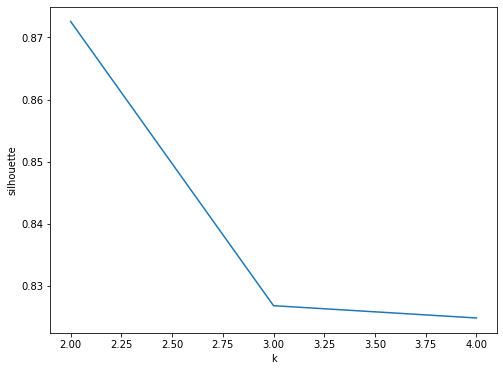

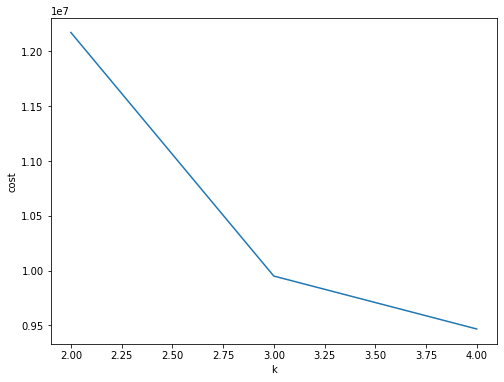

In [48]:
#model
def call_model(sdf):
    id_list=get_ids(sdf)
    
    #create statistics dataframe
    statistics_schema = StructType([
    StructField("id", StringType()),
    StructField("k", IntegerType()),
    StructField("Silhouette", FloatType()),
    StructField("n_per_k", ArrayType(IntegerType())),
    StructField("dtc", ArrayType(FloatType())),
    StructField("rfc", ArrayType(FloatType())),
    StructField("gbt", ArrayType(FloatType()))])
    
    statistics = spark.createDataFrame([], statistics_schema)
    
    iteration=1
    for i in np.nditer(id_list):
        sdf_by_id = sdf.filter(sdf.uid.like(str(i)+"-"+"%")) #filter IDs
        print("customer "+ str(iteration)+": "+ str(i))
        
        sdf_kmeans=prepare_for_kmeans(sdf_by_id)
        
        #sdf_kmeans=pca_for_kmeans(sdf_kmeans) 
        
        #train_data,test_data = sdf_kmeans.randomSplit([0.7,0.3])
        kmeans_model,best_k,silhouette=kmeans(sdf_kmeans)
        print("Silhouette with squared euclidean distance = " + str(silhouette))
        print("best k= "+ str(best_k))
        
        transformed = kmeans_model.transform(sdf_kmeans).select('uid', 'prediction','features')
        transformed.show()
        sdf_join = transformed.join(sdf_by_id, on=['uid'], how='inner')
        sdf_join.show()
        
        #define statistics variables
        n_per_k=[]
        dtc=[]
        rfc=[]
        gbt=[]
        
        for k in range(0,best_k):
            temp_sdf=sdf_join.filter(sdf_join.prediction == k) 
            temp_sdf_malicious=create_malicious_df(temp_sdf)
            temp_sdf_mixed= temp_sdf.union(temp_sdf_malicious)
            tree_data=prepare_for_decision_tree_methods(temp_sdf_mixed)
            
            tree_data=pca_for_tree(tree_data)
            
            train_data,test_data = tree_data.randomSplit([0.7,0.3])
            dtc_acc,rfc_acc,gbt_acc=decision_tree(train_data,test_data)
            print('A single decision tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
            print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
            print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(gbt_acc*100))
            
            n_per_k.append(int(temp_sdf.count()))
            dtc.append(float(dtc_acc))
            rfc.append(float(rfc_acc))
            gbt.append(float(gbt_acc))
            
        
        #update statistics
        newRow_for_statistics = spark.createDataFrame([(str(i), int(best_k), float(silhouette), n_per_k, dtc, rfc, gbt)])
        statistics = statistics.union(newRow_for_statistics)
        
        iteration+=1
        
        
    return statistics

#statistics=call_model(sdf)
#statistics.show()
#save
# result_pdf = statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'statistics.pkl'))
#load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'statistics.pkl'))
#df.head()

sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)

# **Useful Commands**

In [18]:
#.describe().show()
#.printSchema()
#.collect()
#.count()

# **Other**

In [19]:
# #create json data from stored dataframe

# def to_json(final):
#     PERIOD=60

#     data_for_json=final.loc[:, final.columns != 'date']

#     def date_to_str(o):
#         if isinstance(o, datetime.datetime):
#             return o.__str__()

#     json_dataframe = pd.DataFrame(columns=['data']) #creates a new dataframe that's empty
#     L  = []

#     import json
#     import datetime
#     import time

#     r, c = data_for_json.shape
#     for i in range(0, r):
#         for j in range(0, c):
#             data = {}
#             data['id'] = data_for_json.columns.values[j]
#             data['power'] = data_for_json.iloc[i][j]
#             data['date']=data_for_json.index.tolist()[i]
#             json_data = json.dumps(data,default=date_to_str)
#             L.append(json_data)
#             #json_dataframe=json_dataframe.append(json_data,ignore_index=True)

#     json_dataframe = pd.DataFrame(L, columns=['data'])
#     return json_dataframe

In [20]:
# #load by schema

# schema = StructType([
#   StructField("num", IntegerType()),
#     StructField("date", TimestampType()),
#     StructField("id", StringType()),
#   StructField("power", ArrayType(
#       StructType([
#           StructField("H0", FloatType(), True),
#           StructField("H1", FloatType(), True),
#           StructField("H2", FloatType(), True),
#           StructField("H3", FloatType(), True),
#           StructField("H4", FloatType(), True),
#           StructField("H5", FloatType(), True),
#           StructField("H6", FloatType(), True),
#           StructField("H7", FloatType(), True),
#           StructField("H8", FloatType(), True),
#           StructField("H9", FloatType(), True),
#           StructField("H10", FloatType(), True),
#           StructField("H11", FloatType(), True),
#           StructField("H12", FloatType(), True),
#           StructField("H13", FloatType(), True),
#           StructField("H14", FloatType(), True),
#           StructField("H15", FloatType(), True),
#           StructField("H16", FloatType(), True),
#           StructField("H17", FloatType(), True),
#           StructField("H18", FloatType(), True),
#           StructField("H19", FloatType(), True),
#           StructField("H20", FloatType(), True),
#           StructField("H21", FloatType(), True),
#           StructField("H22", FloatType(), True),
#           StructField("H23", FloatType(), True)
#       ])
#    )
#              )])

# a = spark.read.format('csv').schema(schema).option("header", "true").load(DATASET_PATH+"f.csv")
# a.show()

In [21]:
# #test pandas_udf

# my_schema = StructType([
#     StructField("id", IntegerType()),
#     StructField("age", IntegerType())])
# df=spark.read.csv("test.csv", header=True,schema=my_schema)
# df.show()
# df.printSchema()

# def plus_one(a):
#     return a+1

# plus_one_udf = pandas_udf(plus_one, returnType=IntegerType())

# df.select(plus_one_udf(col("age"))).show()

In [22]:
# #test pandas_udf (for array input)

# df = spark.createDataFrame([([1,2,3,4,5,6],'val1'),([4,5,6,7,8,9],'val2')],['col1','col2'])
# df.show()

# @pandas_udf(ArrayType(LongType()))
# def func(v):
#     res=[]
#     for row in v:
#         temp=[]
#         for k in range(len(row)):
#             if (k<=2) or (k>4):
#                 temp.append(row[k])
#             else:
#                 temp.append(row[k]*0)
#         res.append(temp)
#     return pd.Series(res)

# df.withColumn('col3',func(df.col1)).show()